# Figure 12 (Temperature as proxy)

To get coefficients, we retrain the model, since this is not saved during the larger experiment

In [1]:
import numpy as np
import pandas as pd

import pdb

from sklearn import linear_model as lm
from sklearn import preprocessing 
from sklearn import model_selection as ms
from sklearn import pipeline
from sklearn.model_selection import train_test_split as tt_split

from scipy.stats import skew
from scipy.stats.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, '../')

import utils

from anchorRegression import AnchorRegression as AR
from anchorRegression import CrossProxyAnchorRegression as XAR
from anchorRegression import TargetedAnchorRegression as TAR
from anchorRegression import CrossTargetedAnchorRegression as XTAR
from anchorRegression import MeanPredictor

## 1. Load data

Note that the best scenario is determined in `results_tempC.ipynb` 

In [2]:
CITY = 0
TEST_SEASON = 2

proxy = 'TempC'
proxies = [proxy]

In [3]:
DATA_PATH = "../data"

files = [
    'BeijingPM20100101_20151231.csv',
    'GuangzhouPM20100101_20151231.csv',
    'ShenyangPM20100101_20151231.csv',
    'ChengduPM20100101_20151231.csv',
    'ShanghaiPM20100101_20151231.csv'
]

dfs = [pd.read_csv(f"{DATA_PATH}/{f}") for f in files]

In [4]:
raw_df = dfs[CITY].drop('No', axis=1)
filt_df = raw_df.dropna()

df, X, y = utils.process_df(filt_df)

In [5]:
dev_year = 2013
drop_season = TEST_SEASON

In [6]:
import utils

data = utils.get_dev_train_test_data(df, X, y, drop_season, dev_year, proxies)

## 2. Fit Estimators

In [7]:
from copy import deepcopy

In [8]:
lr = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), 
                        ('pred', lm.LinearRegression(fit_intercept=True, normalize=False))])

baselines = {
    'OLS':  
        {'pipe': deepcopy(lr), 
         'drop_cols': proxies, 
         'fit_params': None}
}

In [9]:
tar_estimators = utils.construct_tar(data, proxies, drop_all=True)
ar_estimators = utils.construct_ar(data, proxies, drop_all=True)

In [10]:
estimators = {**baselines,
              **ar_estimators, 
              **tar_estimators}

In [11]:
for k, est in estimators.items():
    if 'tune_lambda' in est.keys() and est['tune_lambda']:
        best_lambda = utils.get_best_lambda(est, data)
        
        print(f"{k}: {best_lambda}")
        
        estimators[k]['pipe'] = estimators[k]['pipe'].set_params(
            **best_lambda)
        
        estimators[k].update(best_lambda)

AR (TempC): {'pred__lamb': 40.0}


In [12]:
for k, est in estimators.items():
    
    perf = {}
    
    # Get cross-validated training errors
    this_X_train = utils.get_estimator_X(data['train']['X'], est)
    this_X_test = utils.get_estimator_X(data['test']['X'], est)
    y_train = data['train']['y']
    y_test = data['test']['y']

    preds_train_cv = ms.cross_val_predict(est['pipe'], this_X_train, y_train, fit_params=est['fit_params'], cv=10)
    resid_train_cv = preds_train_cv - y_train
    
    perf['Train (CV)'] = {
        'preds': preds_train_cv,
        'resid': resid_train_cv.values
    }
    
    # Train on the full training set    
    if est['fit_params'] is not None:
        est['fit'] = est['pipe'].fit(this_X_train, y_train, **est['fit_params'])
    else:
        est['fit'] = est['pipe'].fit(this_X_train, y_train)
        
    # Evaluate on the test set
    preds_test = est['fit'].predict(this_X_test)
    resid_test = preds_test - y_test

    perf['Test'] = {
        'preds': preds_test,
        'resid': resid_test.values
    }
    
    estimators[k]['perf'] = perf

## Construct Figure 12

First, examine the intercepts, then the coefficients.

In [13]:
for k, est in estimators.items():
    if k != 'Mean':
        print(f"Intercept: {est['fit']['pred'].intercept_:.3f} [{k}]")

Intercept: 4.087 [OLS]
Intercept: 4.087 [AR (TempC)]
Intercept: 3.885 [TAR (TempC)]


In [14]:
labels = {
     'OLS' : 'OLS',
     'AR (TempC)' : 'PAR (TempC)',
     'TAR (TempC)' : 'PTAR (TempC)' 
}

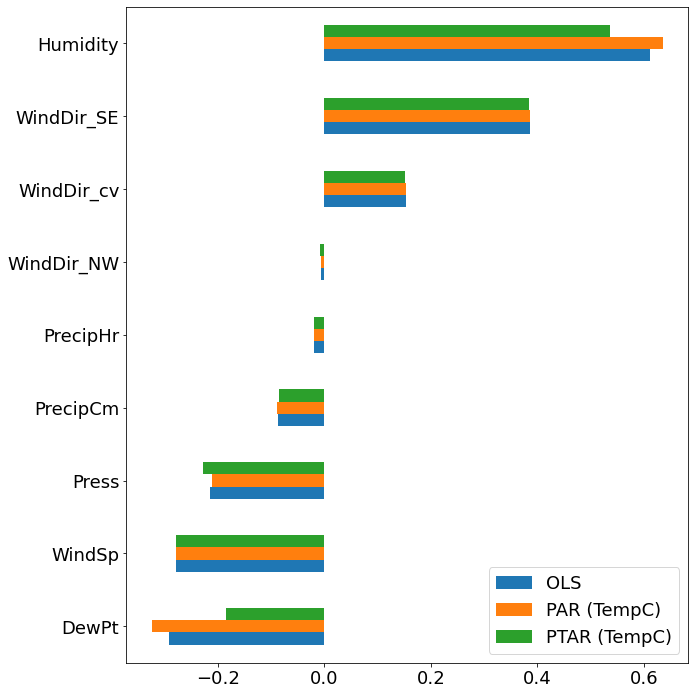

In [15]:
plt.rcParams.update({'font.size': 18})
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharex=True, sharey=True)

coefs = []
ests = []
for k, est in estimators.items():
    if k in ['OLS', 'TAR (TempC)', 'AR (TempC)']:
        this_X = utils.get_estimator_X(data['train']['X'], est)
        coefs.append(pd.Series(est['fit']['pred'].coef_, index = this_X.columns).sort_values())
        ests.append(labels[k])

coef = pd.concat(coefs, axis=1)
coef.columns = ests

coef.plot(kind = "barh", ax=ax)
#ax.set_title("Comparison of Coefficients")

plt.tight_layout()
plt.savefig("../figs/coefficient_comparison.pdf")